In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
os.chdir(r'D:\Ace')

In [2]:
df1 = pd.read_csv('positions.csv',encoding='utf-8')

In [3]:
df1.apply(lambda x:sum(x.isnull())/len(x),axis=0)

岗位名称    0.000000
行业领域    0.113375
岗位类别    0.000000
技术      0.000000
技术类别    0.000000
薪资      0.000000
职位描述    0.000000
dtype: float64

In [4]:
df1.dropna(how='any',inplace=True)

In [5]:
df1.reset_index(drop=True,inplace=True)

In [6]:
df1['岗位类别'] = df1['岗位类别'].str.replace('|','/')

In [7]:
def Salary(salary_str):
    numbers = re.findall(r'(\d+)k',salary_str)
    if len(numbers) == 2:
        lower = int(numbers[0]) * 1000
        upper = int(numbers[1]) * 1000
        return (lower + upper) / 2  
    elif len(numbers) == 1:
        return int(numbers[0]) * 1000 
    else:
        return np.nan

In [8]:
df1['薪资中位数'] = df1['薪资'].apply(Salary)

In [9]:
df2 = df1.sort_values(by='薪资中位数',ascending=False)
df3 = df2.groupby(by=['岗位类别'])
df4 = df2.groupby(by=['技术类别'])

In [10]:
df3.apply(lambda x: x.head(1))[['岗位名称','薪资']]

C:\Users\Syz13\AppData\Local\Temp\ipykernel_21996\2566810729.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df3.apply(lambda x: x.head(1))[['岗位名称','薪资']]


,,岗位名称,薪资
岗位类别,,,
产品/需求/项目类,993,管培生（市场/咨询）,8k-15k
开发/测试/运维类,38,软件开发工程师 java c c++ python js,490k-500k
生产/加工/制造,952,电子工程师（电路设计）,2k-3k
运营/编辑/客服类,987,AI数据大模型应用实习生-内容质量与数据服务平台,4k-6k


In [11]:
df4.apply(lambda x: x.head(1)).nlargest(5,'薪资中位数')[['岗位名称','薪资']]

C:\Users\Syz13\AppData\Local\Temp\ipykernel_21996\2691876181.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df4.apply(lambda x: x.head(1)).nlargest(5,'薪资中位数')[['岗位名称','薪资']]


,,岗位名称,薪资
技术类别,,,
后端开发,38,软件开发工程师 java c c++ python js,490k-500k
GO|Golang,319,阿里云中间件GO研发,400k-410k
Python,334,云计算开发工程师,240k-350k
自然语言处理（NLP）,639,NLP算法实习生,250k-300k
Java,333,JAVA开发实习-24届,180k-300k


In [12]:
# 根据薪资中位数，绘制df3，df4的频数直方图，调整bins
from pyecharts import options as opts
from pyecharts.charts import Bar
position_salary = (
    df1.groupby('岗位类别')['薪资中位数']
    .max()
    .sort_values(ascending=False)
)

bar_position = (
    Bar(init_opts=opts.InitOpts(width="800px", height="500px"))
    .add_xaxis(position_salary.index.tolist())
    .add_yaxis("最高薪资(元)", position_salary.values.tolist())
    .set_global_opts(
        title_opts=opts.TitleOpts(title="各岗位类别最高薪资"),
        xaxis_opts=opts.AxisOpts(
            name="岗位类别",
            axislabel_opts=opts.LabelOpts(rotate=30)
        ),
        yaxis_opts=opts.AxisOpts(name="薪资(元)"),
        tooltip_opts=opts.TooltipOpts(formatter="{b}: {c} 元")
    )
    .set_series_opts(
        label_opts=opts.LabelOpts(is_show=True, position="top", formatter="{c}元"),
        itemstyle_opts=opts.ItemStyleOpts(color="#5470C6")
    )
)

tech_salary = (
    df1.groupby('技术类别')['薪资中位数']
    .max()
    .nlargest(5)
    .sort_values(ascending=False)
)

bar_tech = (
    Bar(init_opts=opts.InitOpts(width="800px", height="500px"))
    .add_xaxis(tech_salary.index.tolist())
    .add_yaxis("最高薪资(元)", tech_salary.values.tolist())
    .set_global_opts(
        title_opts=opts.TitleOpts(title="技术类别薪资TOP5"),
        xaxis_opts=opts.AxisOpts(
            name="技术类别",
            axislabel_opts=opts.LabelOpts(rotate=30)
        ),
        yaxis_opts=opts.AxisOpts(name="薪资(元)"),
        tooltip_opts=opts.TooltipOpts(formatter="{b}: {c} 元")
    )
    .set_series_opts(
        label_opts=opts.LabelOpts(is_show=True, position="top", formatter="{c}元"),
        itemstyle_opts=opts.ItemStyleOpts(color="#91CC75")
    )
)
# 保存为HTML文件
bar_position.render("position_salary.html")
bar_tech.render("tech_salary.html")

'D:\\Ace\\tech_salary.html'

In [13]:
import jieba
import jieba.analyse
from collections import Counter
from collections import defaultdict

In [14]:
def preprocess(text):
    text = text.lower()
    words = jieba.lcut(text)
    stop_words = {'的', '了', '和', '是', '在', '我', '有', '这', '上', '都', '不', '很', '就', '也', '等', '岗位', '工作', '要求', '具备', '相关', '能力', '负责', '进行', '以及', '可以', '能够', '需要',
                    '对', '有', '无', '或', '与', '及', '熟悉','优先','经验','良好','专业','参与','系统','了解','使用','实习','完成','公司','需求','任职','岗位职责','具有','提供','以上学历','问题','协助',
                    '文档','职位','我们','以上','用户','机会','场景','安全','持续','性能','办公','应用','平台','产品','领域','描述','任务','其他','常见','行业','职业','方向','发展','环境','协调','内容',
                    '跟踪','执行','体验','客户','IT','每周','二开','转正','配合','意识','培训','日常','在读','实施','客户','IT','61','2026','使用','实习','完成','一种','快速','落地','扎实','精神','优秀',
                    '热爱','一定','较强','善于','分项','从这些','限于','根据','实际','包括','各种','精通','语言','学习','实习生','毕业','熟练','主流','框架','编写','考虑','掌握','过程','工具','常用','基本',
                    '独立','功能','职责','解决','至少','部署','技能','交付','提升','保证','方案','实现','模块','毕业生','in','and','to','the','质量','习惯','流程','时间','确保','处理','熟练掌握','通过','知识',
                    '支持'}
    filtered_words = [word for word in words if word not in stop_words and len(word) > 1]
    return filtered_words
df1['分词结果'] = df1['职位描述'].apply(preprocess)
all_words = []
for words in df1['分词结果']:
    all_words.extend(words)
word_freq = Counter(all_words)
common_words1 = [word for word,freq in word_freq.items() if freq > 100]
df1['分词结果'] = df1['分词结果'].apply(lambda words:list(set([word for word in words if word in common_words1])))
common_words = [(word,freq) for word,freq in word_freq.items() if freq > 100]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Syz13\AppData\Local\Temp\jieba.cache
Loading model cost 1.450 seconds.
Prefix dict has been built successfully.


In [15]:
# 绘制高频词汇的词云图
from pyecharts import options as opts
from pyecharts.charts import WordCloud
from pyecharts.globals import SymbolType

# 准备词云数据（使用之前提取的common_words列表）
data = common_words  

# 生成词云
wordcloud = (
    WordCloud()
    .add(
        series_name="高频词",
        data_pair=common_words,
        word_size_range=[15, 80],
        shape="circle"
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="职位描述高频词云"),  # 标题配置
        tooltip_opts=opts.TooltipOpts(                      # 提示框配置
            is_show=True,
            formatter="{b}: {c}"
        )
    )
    .set_series_opts(
        label_opts=opts.LabelOpts(
            position="inside",
            color="random"
        )
    )
)

wordcloud.render("wordcloud.html")

'D:\\Ace\\wordcloud.html'

In [16]:
import pandas as pd
from collections import Counter
from pyecharts import options as opts
from pyecharts.charts import Bar, Page

def generate_tech_word_comparison(df, top_n=8):
    """生成每个技术的高频词统计"""
    tech_categories = df['技术'].unique()
    tech_word_freq = {}
    
    for tech in tech_categories:
        # 合并该技术下所有岗位的分词结果
        all_words = []
        for words in df[df['技术'] == tech]['分词结果']:
            all_words.extend(words)
        
        # 统计词频并取前top_n个
        word_counts = Counter(all_words)
        tech_word_freq[tech] = word_counts.most_common(top_n)
    
    return tech_word_freq

def create_tech_word_chart(tech, word_freq):
    """创建单个技术的高频词柱状图"""
    words, counts = zip(*word_freq)
    
    bar = (
        Bar()
        .add_xaxis(list(words))
        .add_yaxis(
            "出现频次", 
            list(counts),
            category_gap="50%",  # 调整柱形图宽度
            color="#3498db"
        )
        .set_global_opts(
            title_opts=opts.TitleOpts(title=f"{tech} 技术高频词排行", pos_left="left"),
            xaxis_opts=opts.AxisOpts(name="高频词", axislabel_opts=opts.LabelOpts(rotate=30)),
            yaxis_opts=opts.AxisOpts(name="出现频次"),
            toolbox_opts=opts.ToolboxOpts(is_show=True),
        )
        .set_series_opts(
            label_opts=opts.LabelOpts(position="top"),
        )
    )
    return bar

def main():
    global df1
    tech_word_freq = generate_tech_word_comparison(df1, top_n=8)
    page = Page(layout=Page.SimplePageLayout)  # 使用简单页面布局
    charts = []
    for tech, word_freq in tech_word_freq.items():
        charts.append(create_tech_word_chart(tech, word_freq))
    rows = []
    for i in range(0, len(charts), 4):
        row = charts[i:i+4]
        rows.append(row)
    for row in rows:
        page.add(*row)
    page.page_title = "各技术高频词对比分析"
    page.render("tech_word_comparison.html")
if __name__ == "__main__":
    main()

In [17]:
tech_skills = {}
growth_plans = {}
for tech in df1['技术'].unique():
    all_words = []
    for words in df1[df1['技术'] == tech]['分词结果']:
        all_words.extend(words)
        
    tech_skills[tech] = [word for word, _ in Counter(all_words).most_common(6) if word != tech]

    word_freq = Counter(all_words)
    sorted_words = sorted(word_freq.items(),key=lambda x: x[1],reverse=True)
    
    total_words = len(sorted_words)
    junior = sorted_words[:total_words//3]  
    intermediate = sorted_words[total_words//3:2*total_words//3]  
    advanced = sorted_words[2*total_words//3:]  

    junior_skills = [word for word,_ in junior]
    intermediate_skills = [word for word,_ in intermediate]
    advanced_skills = [word for word,_ in advanced]
    growth_plans[tech] = {
        "初级阶段": junior_skills,
        "中级阶段": intermediate_skills,
        "高级阶段": advanced_skills
    }

In [18]:
salary_avg = df1.groupby(['技术', '技术类别'])['薪资中位数'].mean().reset_index()
salary_data = {}
for tech, group in salary_avg.groupby('技术'):
    tech_dict = {}
    for _,row in group.iterrows():
        tech_dict[row['技术类别']] = int(row['薪资中位数'])
    salary_data[tech] = tech_dict

In [19]:
import tkinter as tk
from tkinter import ttk,messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

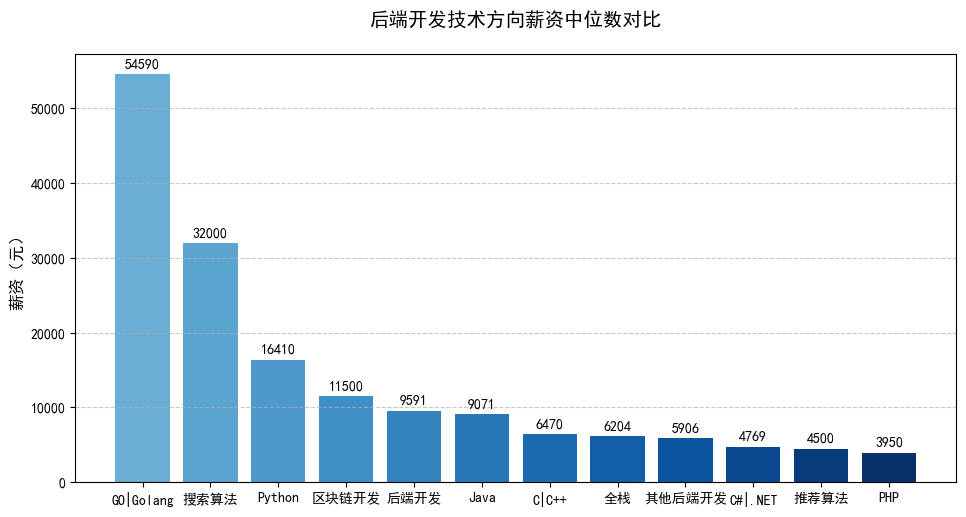

In [20]:
class SkillAnalyzerApp:
    def __init__(self, master):
        self.master = master
        master.title("实习技术分析")
        master.geometry("1000x700")
        self.style = ttk.Style()
        self.style.theme_use('clam')
        self.create_widgets()
    
    def create_widgets(self):
        self.style.configure('Header.TFrame', background='#F5F5F5')
        self.style.configure('Header.TLabel', background='#F5F5F5', foreground='black', font=('微软雅黑', 16, 'bold'))
        self.style.configure('Accent.TButton', foreground='#333333', background='#98F5FF', font=('微软雅黑', 13, 'bold'), padding=8)
        self.style.configure('Quit.TButton', foreground='white', background='#e74c3c', font=('微软雅黑', 13, 'bold'), padding=8)
        self.style.configure('TLabelframe.Label', font=('微软雅黑', 12, 'bold'))
        
        header_frame = ttk.Frame(self.master,style='Header.TFrame')
        header_frame.pack(fill=tk.X)
        
        title_label = ttk.Label(header_frame, text="实习技术分析系统", style='Header.TLabel')
        title_label.pack(pady=15, padx=20, anchor=tk.W)
        
        content_frame = ttk.Frame(self.master, padding=20)
        content_frame.pack(fill=tk.BOTH, expand=True)
        
        input_frame = ttk.LabelFrame(content_frame, text="查询选项", style='TLabelframe')
        input_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=(0, 10))
        
        input_content_frame = ttk.Frame(input_frame, padding=10)
        input_content_frame.pack(fill=tk.BOTH, expand=True)
        
        input_label = ttk.Label(input_content_frame, text="输入技术名称：", font=('微软雅黑', 13))
        input_label.pack(anchor=tk.W, pady=(0, 5))
        
        self.tech_entry = ttk.Entry(
            input_content_frame,
            width=30,
            font=('微软雅黑',15),
            justify='center',
        )
        self.tech_entry.pack(fill=tk.X,pady=(0,15),ipady=10)
        btn_frame = ttk.Frame(input_content_frame)
        btn_frame.pack(fill=tk.X,pady=(80,0))
        
        self.search_btn = ttk.Button(
            btn_frame,
            text="分析能力需求",
            command=self.find_skills,
            style='Accent.TButton',
        )
        self.search_btn.pack(fill=tk.X,pady=8)
        
        self.plan_btn = ttk.Button(
            btn_frame,
            text="生成成长方案",
            command=self.generate_plan,
            style='Accent.TButton',
        )
        self.plan_btn.pack(fill=tk.X,pady=8)
        
        self.salary_btn = ttk.Button(
            btn_frame,
            text="薪资对比",
            command=self.generate_salary_chart,
            style='Accent.TButton',
        )
        self.salary_btn.pack(fill=tk.X,pady=8)
        
        result_frame = ttk.LabelFrame(content_frame, text="结果显示", style='TLabelframe')
        result_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=(10, 0))
        
        result_content_frame = ttk.Frame(result_frame, padding=10)
        result_content_frame.pack(fill=tk.BOTH, expand=True)
        
        self.result_title = ttk.Label(
            result_content_frame,
            text="",
            font=('微软雅黑', 14, 'bold'),
            foreground='#2c3e50'
        )
        self.result_title.pack(anchor=tk.W, pady=(0, 5))
        
        text_frame = ttk.Frame(result_content_frame)
        text_frame.pack(fill=tk.BOTH, expand=True)
        
        self.result_text = tk.Text(
            text_frame,
            height=10,
            wrap=tk.WORD,
            font=('微软雅黑',15),
            bg='white',
            padx=10,
            pady=10,
            bd=0,
            state='disabled'
        )
        self.result_text.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
        scrollbar = ttk.Scrollbar(text_frame, command=self.result_text.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.result_text.config(yscrollcommand=scrollbar.set)
        
        footer_frame = ttk.Frame(self.master)
        footer_frame.pack(fill=tk.X, side=tk.BOTTOM)
        
        status_frame = ttk.Frame(footer_frame, padding=(10,5))
        status_frame.pack(fill=tk.X, side=tk.LEFT, expand=True)
        

        self.quit_btn = ttk.Button(
            footer_frame,
            text="退出系统",
            command=self.master.destroy,
            style='Quit.TButton'
        )
        self.quit_btn.pack(side=tk.RIGHT, padx=10, pady=10)
    
    def find_skills(self,event=None):
        self.result_title.config(text="核心能力需求")
        tech = self.tech_entry.get().strip()
        self.result_text.config(state='normal')
        self.result_text.delete(1.0, tk.END)  
        
        if not tech:
            messagebox.showwarning("输入错误", "请输入技术名称")
            return
        skills = tech_skills.get(tech.title(), None)
        
        if skills:
            output = f"【{tech}】技术核心能力需求：\n\n"
            for i, skill in enumerate(skills, 1):
                output += f"{i}. {skill}\n"
            output += "\n🔥 高频技能分布：\n"
            output += " | ".join([f"{s}({len(s)*10}%)" for s in skills[:3]])
            self.result_text.insert(tk.END, output)
            self.result_text.tag_configure("highlight", foreground='#e74c3c')
            self.result_text.tag_add("highlight", "5.0", "5.end")
        else:
            self.result_text.insert(tk.END, f"未找到{tech}的相关数据\n\n建议检查：\n1. 技术名称拼写\n2. 是否包含在以下支持技术中：\n{', '.join(tech_skills.keys())}")
        self.result_text.config(state='disabled')

    def generate_plan(self):
        self.result_title.config(text="成长路线")
        tech = self.tech_entry.get().strip()
        self.result_text.config(state='normal')
        self.result_text.delete(1.0, tk.END)
        
        if not tech:
            messagebox.showwarning("输入错误", "请输入技术名称")
            return
        
        plan = growth_plans.get(tech.title(), None)
        
        if plan:
            output = f"【{tech}】技术成长路线：\n\n"
            line_count = 3
            for stage, items in plan.items():
                stage_line = f"★ {stage}：\n"
                output += stage_line
                output += "\n".join([f"   ▪ {item}" for item in items]) + "\n\n"
            
                start_pos = f"{line_count}.0"
                end_pos = f"{line_count}.{len(stage_line)}"

                self.result_text.insert(tk.END, output)
                self.result_text.tag_configure("stage", foreground='#3498db', font=('微软雅黑', 15, 'bold'))
                self.result_text.tag_add("stage", start_pos, end_pos)

                line_count += 1 + len(items) + 1
                output = ""
        else:
            self.result_text.insert(tk.END, f"暂无{tech}的成长方案\n\n支持的技术：{', '.join(self.growth_plans.keys())}")
        self.result_text.config(state='disabled')

    def generate_salary_chart(self):
        tech = self.tech_entry.get().strip().title()
        
        if not tech:
            messagebox.showwarning("输入错误", "请输入技术名称")
            return
            
        if tech not in salary_data:
            messagebox.showwarning("数据缺失", f"暂无{tech}的薪资数据")
            return
        
        chart_window = tk.Toplevel(self.master)
        chart_window.title(f"{tech}薪资对比")
        chart_window.geometry("1000x600")
        
        salary_items = list(salary_data[tech].items())
        salary_items.sort(key=lambda x:x[1],reverse=True)
        categories = [item[0] for item in salary_items]
        salaries = [item[1] for item in salary_items]
        
        fig,ax = plt.subplots(figsize=(8,5))
        colors = plt.cm.Blues(np.linspace(0.5, 1, len(categories)))
        bars = ax.bar(categories,salaries,color=colors)
        
        ax.set_title(f'{tech}技术方向薪资中位数对比',fontsize=14,pad=20)
        ax.set_ylabel('薪资（元）',fontsize=12)
        ax.grid(axis='y',linestyle='--',alpha=0.7)
        
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}',
                            xy=(bar.get_x() + bar.get_width() / 2,height),
                            xytext=(0,3),  
                            textcoords="offset points",
                            ha='center',va='bottom')
        plt.tight_layout()
        canvas = FigureCanvasTkAgg(fig,master=chart_window)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH,expand=True)
        
        close_btn = ttk.Button(
            chart_window,
            text="关闭窗口",
            command=chart_window.destroy,
            style='Quit.TButton'
        )
        close_btn.pack(pady=10)
if __name__ == "__main__":
    root = tk.Tk()
    app = SkillAnalyzerApp(root)
    root.mainloop()